# Computing the price of a Bermudean call option

We import the necessary libraries.

In [21]:
import math
import numpy as np
import scipy.stats
from tqdm import tqdm
import matplotlib.pyplot as plt

A Bermudean option is a type of exotic options contract that can only be exercised on predetermined dates. In other words, it gives the holder of the option the right to exercise on a specific set of dates during the life of the option. The name is quite telling because it is a blend of the two other popular vanilla options, namely the American option and European option, and it got its name from the place Bermuda, which lies between these two places.  
In a frictionless complete market, the price of a Bermudean option is given by :  

$$V_0(s) = \max_{t \in \{t_1, t_2, \ldots, t_N\}} \mathbb{E} \left[ e^{-rt} g(S_t) \, \middle| \, S_0 = s \right]$$

Where :

- $V_0(s)$ represents the price of the Bermudan option at time $t = 0$ when the underlying stock price is $S_0 = s$.
- $\tau$ represents the stopping time, which determines when the option holder can exercise the option. The set $\{\tau_1, \tau_2, \ldots, \tau_N\}$ represents the predetermined exercise dates.
- $g$ is the payoff function of the option.

Despite its widespread significance, the valuation of early-exercise features remains a dif- ficult problem in many important settings where there is no analytical solution, even for relatively simple models.
However, binomial, lattice and finite-difference methods can be used to generate numerical solutions to pricing problems with one or two sources of uncertainty.  
For this project, we will study
__The Nested Monte Carlo approach using Random Tree Method__ developed by __Broadie and Glasserman__ in :  
Mark Broadie and Paul Glasserman. “Pricing American-style securities using simu- lation”. In: Journal of economic dynamics and control 21.8-9 (1997), pp. 1323–1352. [PDF File](https://github.com/AimadeddineHakim/Monte-Carlo_Bermudean/blob/58df1dc837a887d38b56a4bb70de243b81c5b809/broadie_glasserman.pdf)


We define the class of trees

In [14]:
class Arbre():
    def __init__(self,val=0,children=None):
        self.val=val
        self.children=children
    def __str__(self):
        child= None
        if not self.children or not self.children[0] : child=[Node for Node in self.children]
        else : child=[Node.val for Node in self.children]
        return "Root : {}, Children : {}".format(self.val,child)

Suppose the stock price follows a geometric brownian motion given by the dynamic :

$$ dS_{t} = r S_{t} dt + \sigma S_{t} dW_{t} $$  
  
  Where $W_{t}$ is the brownian motion, $r$ is the short rate and $\sigma$ is the volatility.  
  
  
From this equation we can derive the recursive solution that gives S_next at a current node given its value S:  
$$S_{t+1} = S_{t} e^{(r - \frac{\sigma^{2}}{2})\Delta t + \sigma \sqrt{\Delta t} \cdot Z_{t+1}}$$  
  
  Where $\Delta t$ is the time step and $(Z_{1}, Z_{2} ... Z_{N})$ is a vector of independent standardized normal variables.

In [15]:
def S_next(s0,r,gamma,sigma,time_delta):
    return s0*np.exp((r-gamma-(sigma**2)/2)*(time_delta)+sigma*math.sqrt(time_delta)*np.random.normal())

We fill our tree with the simulated values of the state variable S (the price of the underlying asset) starting at S0

In [16]:
# T is the final time, S0 the spot price at time t=0 and d is the branching parameter
def option_tree(s0,T,d):
    if T:
        children=[]
        for i in range(d):
            children.append(option_tree(S_next(s0,r,gamma,sigma,time_delta),T-1,d))
        return Arbre(s0,children)

### Dynamic Programming Principle 


Let $g_i$ denote the payoff of the option at time $t_i$ and $V_i(s)$ the value of the option at $t_i$ given $S_i = s$, assuming the option has not been exercised before time $t_i$. Our goal is to price the Bermudean option at time 0, meaning we need to compute $V_0(S_0)$.

In discrete time, the Dynamic Programming Principle (DPP) offers a characterization of the option as follows:

- For the final time step $N$:

$$V_N(s) = g_N(s)$$

- For an intermediary time step $i-1$:

$$V_{i-1}(s) = \max \left( g_{i-1}(s), \mathbb{E}\left[ e^{-r\Delta} V_i(S_i) \,|\, S_{i-1} = s \right] \right)$$  
So, in order to compute the option value at time 0, we need make an approximation of :  
  
  $$ \mathbb{E}\left[ e^{-r\Delta} V_i(S_i) \,|\, S_{i-1} = s \right] $$


# Part 1

We first lay the recursive method that will allow us to compute the __high estimator__ of a Bermudean call option using the Dynamic Programming as described in the article [PDF File](https://github.com/AimadeddineHakim/Monte-Carlo_Bermudean/blob/58df1dc837a887d38b56a4bb70de243b81c5b809/broadie_glasserman.pdf)



In [17]:
# t is a tree and k the strike of the Bermudean call option
def payoff(t,k,r,time_delta):
    if not t: return None #if empty Tree
    elif not t.children or not t.children[0]:                                           
        return Arbre(max(0,k-t.val),t.children)
    else: 
        children=[]
        nodes=[]
        for child in t.children:
            children.append(payoff(child,k,r,time_delta))
            nodes.append(children[-1].val)
        return Arbre(max(max(k-t.val,0),np.exp(-r*time_delta)*np.mean(nodes)),children)

# Part 2

We first lay the recursive method that will allow us to compute the __low estimator__ of a Bermudean call option as described in the article. [PDF File](https://github.com/AimadeddineHakim/Monte-Carlo_Bermudean/blob/58df1dc837a887d38b56a4bb70de243b81c5b809/broadie_glasserman.pdf)



In [18]:
def rec(arbre,k,r,time_delta):
    if not arbre : return None
    if not arbre.children or not  arbre.children[0]: return Arbre(max(0,k-arbre.val),arbre.children)
    children=[]
    nodes=[]
    for child in arbre.children:
        children.append(rec(child,k,r,time_delta))
        nodes.append(children[-1].val)
        val=0
    for i in range(len(nodes)):
        if max(0,k-arbre.val)>=np.exp(-r*time_delta)*((sum(nodes)-nodes[i])/(len(nodes)-1)):
            children[i].val=max(0,k-arbre.val)
        else:
            children[i].val=np.exp(-r*time_delta)*children[i].val
        val+=children[i].val
    return Arbre(val/len(nodes),children)  

# Part 3

We compute the average and the standard deviation of the low and high estimators given $s_0$ and a maturity $T$

In [19]:
def deviance_low(s0,T,d,r,time_delta,k,n_simul):
    teta=[]
    for i in tqdm(range(n_simul)):
        teta.append(rec(option_tree(s0,T,d),k,r,time_delta).val)
    m = np.mean(teta)
    s = np.std(teta, ddof = 1)
    return m, s

def deviance_high(s0,T,d,r,time_delta,k,n_simul):
    teta=[]
    for i in tqdm(range(n_simul)):
        teta.append(payoff(option_tree(s0,T,d),k,r,time_delta).val)

    m = np.mean(teta)
    s = np.std(teta, ddof = 1)
    return m, s
  
def interval(s0,T,d,r,time_delta,k,n_simul):
    m_low, s_low = deviance_low(s0,T,d,r,time_delta,k,n_simul)
    m_high, s_high = deviance_high(s0,T,d,r,time_delta,k,n_simul)
    return m_low-1.96*s_low/np.sqrt(n_simul), m_high+1.96*s_high/np.sqrt(n_simul),  m_low, m_high

def IC_Inf(s0,T,d,r,time_delta,k,n_simul):
    m_low, s_low = deviance_low(s0,T,d,r,time_delta,k,n_simul)
    return m_low-1.96*s_low/np.sqrt(n_simul)

def IC_Sup(s0,T,d,r,time_delta,k,n_simul):
    m_high, s_high = deviance_high(s0,T,d,r,time_delta,k,n_simul)
    return m_high+1.96*s_high/np.sqrt(n_simul)

def t_low(s0,T,d,r,time_delta,k,n_simul):
    m_low, s_low = deviance_low(s0,T,d,r,time_delta,k,n_simul)
    return m_low

def t_high(s0,T,d,r,time_delta,k,n_simul):
    m_high, s_high = deviance_high(s0,T,d,r,time_delta,k,n_simul)
    return m_high

We plot the exact value of a European call option value and compare it to our point estimate of the Bermudean call option value for different spot prices. 

In [20]:
k,r,sigma,gamma,T = 100,0.05,0.2,0,3
n_simul,d,time_delta = 100,10,1
s0_list = np.arange(70,240,20)
intervals = [interval(s0,T,d,r,time_delta,k,n_simul) for s0 in s0_list]
IC_Infs = [IC_Inf(s0,T,d,r,time_delta,k,n_simul) for s0 in s0_list]
IC_Sups = [IC_Sup(s0,T,d,r,time_delta,k,n_simul) for s0 in s0_list]
t_lows = [t_low(s0,T,d,r,time_delta,k,n_simul) for s0 in s0_list]
t_highs = [t_high(s0,T,d,r,time_delta,k,n_simul) for s0 in s0_list]
point_estimate = (np.array(t_highs) + np.array(t_lows))/2

100%|████████████████████████████████████████| 100/100 [00:00<00:00, 255.79it/s]


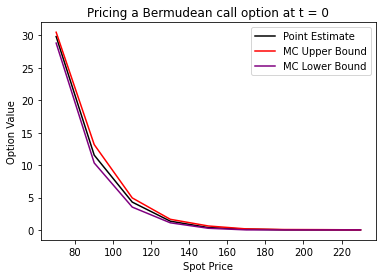

In [12]:
plt.figure()
plt.plot(s0_list,point_estimate,c="black",label="Point Estimate")
plt.plot(s0_list,IC_Sups,c="red",label="MC Upper Bound")
plt.plot(s0_list,IC_Infs,c="purple",label="MC Lower Bound")
plt.xlabel("Spot Price")
plt.ylabel("Option Value")
plt.title("Pricing a Bermudean call option at t = 0", loc = "center")
plt.legend(loc="best")